# Elevation Data Download

In [71]:
# Import necessary packages
import os
import pathlib
import earthaccess
import xrspatial
import geopandas as gdp
from glob import glob
import rioxarray as rxr
import rioxarray.merge as rxrmerge
import matplotlib.pyplot as plt
import warnings

In [35]:
%store -r habitat1_gdf habitat2_gdf project_dir

In [36]:
# Define data directory for Sheyenne National Grassland and Little Missouri National Grassland
habitat1_elevation_dir = os.path.join(project_dir, 'habitat1_elevation_strm')
habitat2_elevation_dir = os.path.join(project_dir, 'habitat2_elevation_strm')


os.makedirs(habitat1_elevation_dir, exist_ok=True)
os.makedirs(habitat2_elevation_dir, exist_ok=True)


In [37]:
# Log in to earthaccess
earthaccess.login()

In [38]:
# Search earthaccess for datasets 
datasets = earthaccess.search_datasets(keyword='SRTM DEM')
for dataset in datasets:
    print(dataset['umm']['ShortName'], dataset['umm']['EntryTitle'])

NASADEM_SHHP NASADEM SRTM-only Height and Height Precision Mosaic Global 1 arc second V001
NASADEM_SIM NASADEM SRTM Image Mosaic Global 1 arc second V001
NASADEM_SSP NASADEM SRTM Subswath Global 1 arc second V001
C_Pools_Fluxes_CONUS_1837 CMS: Terrestrial Carbon Stocks, Emissions, and Fluxes for Conterminous US, 2001-2016
SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
GEDI01_B GEDI L1B Geolocated Waveform Data Global Footprint Level V002
GEDI02_B GEDI L2B Canopy Cover and Vertical Profile Metrics Data Global Footprint Level V002
NASADEM_HGT NASADEM Merged DEM Global 1 arc second V001
SRTMGL3 NASA Shuttle Radar Topography Mission Global 3 arc second V003
SRTMGL1_NC NASA Shuttle Radar Topography Mission Global 1 arc second NetCDF V003
SRTMGL30 NASA Shuttle Radar Topography Mission Global 30 arc second V002
GFSAD30EUCEARUMECE Global Food Security-support Analysis Data (GFSAD) Cropland Extent 2015 Europe, Central Asia, Russia, Middle East product 30 m V001
GFSAD30SA

# Habitat 1 - Sheyenne National Grassland Soil Data

In [56]:
# Define data search for habitat 1
habitat1_srtm_pattern = os.path.join(habitat1_elevation_dir, '*.hgt.zip') # I feel there is a way to make this a function but I am running out of time

# Define bounds for habitat 2
bounds_habitat1 = tuple(habitat1_gdf.total_bounds)
buffer = .05 
xmin, ymin, xmax, ymax = bounds_habitat1
bounds_habitat1_buffer = (xmin-buffer, ymin-buffer, xmax+buffer, ymax+buffer)

if not glob(habitat1_srtm_pattern):
    habitat1_srtm_results = earthaccess.search_data(
        short_name="SRTMGL1",
        bounding_box=bounds_habitat1_buffer
    )
    habitat1_srtm_results = earthaccess.download(habitat1_srtm_results, habitat1_elevation_dir)
else:
    print("Files already exist. Skipping download.")

Files already exist. Skipping download.


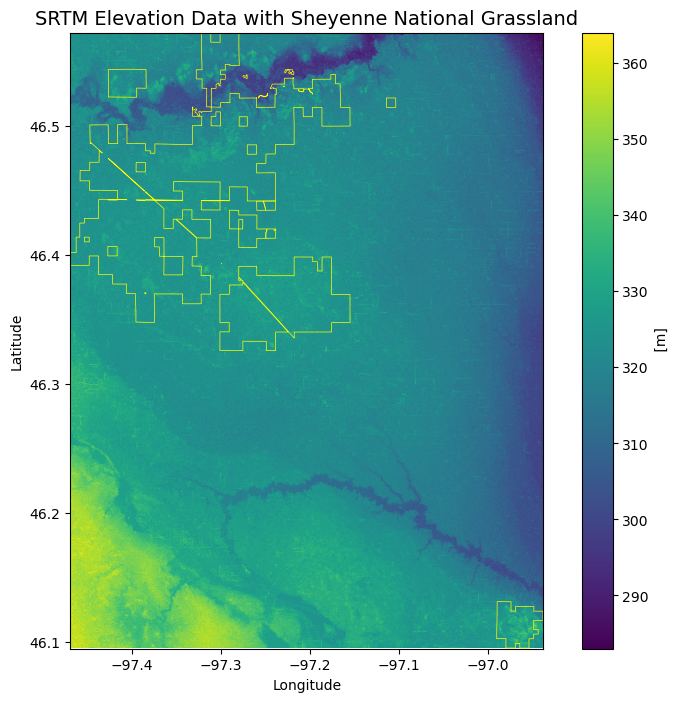

In [57]:
# Create a list
habitat1_srtm_da_list = []
bounds_habitat1_buffer = tuple(habitat1_gdf.total_bounds)
for habitat1_srtm_path in glob(habitat1_srtm_pattern):
    tile_da = rxr.open_rasterio(habitat1_srtm_path, mask_and_scale=True).squeeze()
    
    # Crop data arrays
    habitat1_cropped_da = tile_da.rio.clip_box(*bounds_habitat1_buffer) 
    habitat1_srtm_da_list.append(habitat1_cropped_da)

# Merge tiles
habitat1_srtm_da = rxrmerge.merge_arrays(habitat1_srtm_da_list)

# Initialize a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figure size as needed

# Plot the DataArray
habitat1_srtm_da.plot(ax=ax)

# Plot the habitat1 boundary on the same axis
habitat1_gdf.boundary.plot(ax=ax, color='yellow', linewidth=0.5)

# Add a title and axis labels
ax.set_title('SRTM Elevation Data with Sheyenne National Grassland', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Display the plot
plt.show()

## Calculate Slope for Habitat 1

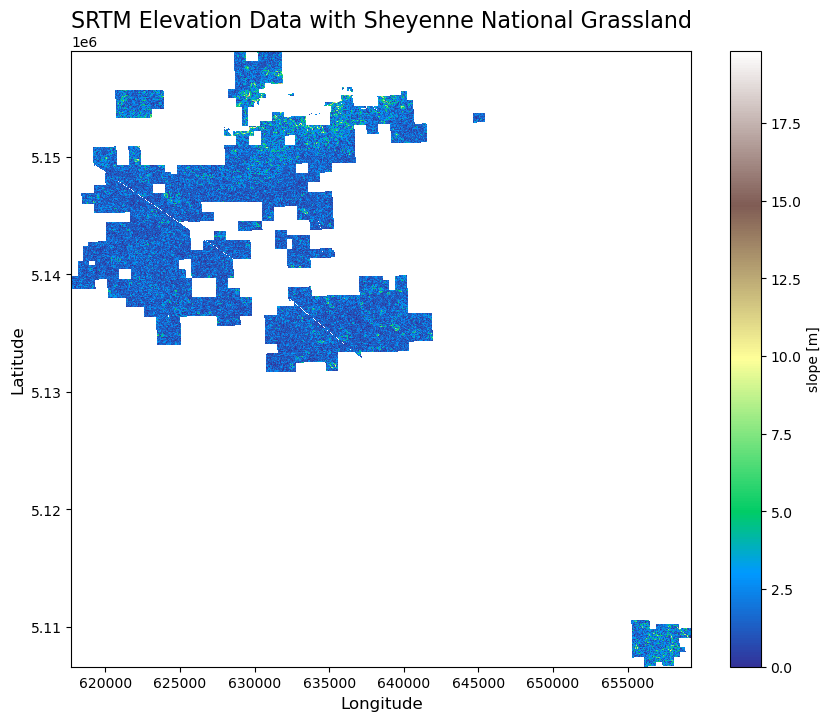

In [44]:
# Reproject and calculate slope
utm14_epsg = 32614
habitat1_srtm_project_da = habitat1_srtm_da.rio.reproject(32614)
habitat1_proj_gdf = habitat1_gdf.to_crs(utm14_epsg)

# Calculate slope
habitat1_slope_full_da = xrspatial.slope(habitat1_srtm_project_da)

# Clip the slope data by the habitat1 boundaries
habitat1_slope_da = habitat1_slope_full_da.rio.clip(habitat1_proj_gdf.geometry)

# Create a figure and axes to ensure consistent plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the slope data
habitat1_slope_da.plot(ax=ax, cmap='terrain')

# Add a title and labels after plotting
ax.set_title('SRTM Elevation Data with Sheyenne National Grassland', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Show the plot
plt.show()


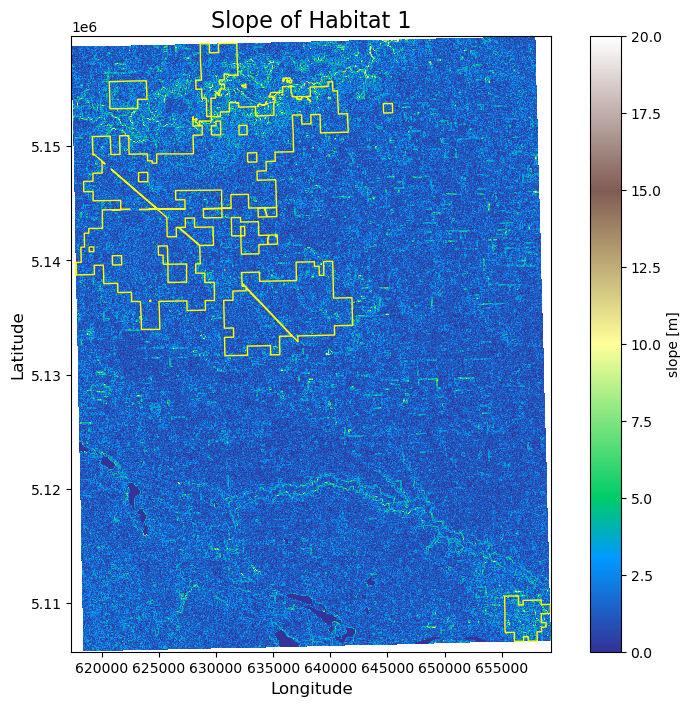

In [67]:
# Calculate the slope
habitat1_slope_da = xrspatial.slope(habitat1_srtm_project_da)

# Initialize a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))  # You can adjust the figure size

# Plot the slope on the specified axis
habitat1_slope_da.plot(ax=ax, cmap='terrain')

# Add the Habitat 1 boundary
habitat1_gdf.to_crs(utm14_epsg).boundary.plot(ax=ax, color='yellow', linewidth=1)

# Add a title and labels
ax.set_title('Slope of Habitat 1', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Display the plot
plt.show()


# Habitat 2 Little Missouri National Grasslands Soil Data

In [80]:
# Define bounding box for habitat2
# bounds_habitat2_buffer = (-103.5, 46.0, -102.5, 47.0)  # Adjusted as needed

# Search for SRTM data
try:
    habitat2_srtm_results = earthaccess.search_data(
        short_name="SRTMGL1",
        bounding_box=bounds_habitat2_buffer
    )
    if not habitat2_srtm_results:
        raise ValueError("No granules found for the specified bounding box.")
    print(f"Number of granules found: {len(habitat2_srtm_results)}")
except Exception as e:
    print(f"Search failed with error: {e}")


Number of granules found: 9


In [84]:
# Define data search for habitat 1
habitat2_srtm_pattern = os.path.join(habitat2_elevation_dir, '*.hgt.zip') # I feel there is a way to make this a function but I am running out of time

# Define bounds for habitat 2
bounds_habitat2 = tuple(habitat2_gdf.total_bounds)
buffer = .1 # Buffer is larger because this is a huge grassland 
xmin, ymin, xmax, ymax = bounds_habitat2
bounds_habitat2_buffer = (xmin-buffer, ymin-buffer, xmax+buffer, ymax+buffer)

if not glob(habitat2_srtm_pattern):
    habitat2_srtm_results = earthaccess.search_data(
        short_name="SRTMGL1",
        bounding_box=bounds_habitat2_buffer
    )
    habitat2_srtm_results = earthaccess.download(habitat2_srtm_results, habitat2_elevation_dir)
else:
    print("Files already exist. Skipping download.")


Files already exist. Skipping download.


In [85]:
# Reproject the habitat2 GeoDataFrame to match the raster's CRS
habitat2_gdf = habitat2_gdf.to_crs(epsg=4326)

In [86]:
# Create a list
habitat2_srtm_da_list = []
bounds_habitat2_buffer = tuple(habitat2_gdf.total_bounds)
for habitat2_srtm_path in glob(habitat2_srtm_pattern):
    tile_da = rxr.open_rasterio(habitat2_srtm_path, mask_and_scale=True).squeeze()
    
    # Crop data arrays
    habitat2_cropped_da = tile_da.rio.clip_box(*bounds_habitat2_buffer) 
    habitat2_srtm_da_list.append(habitat2_cropped_da)

# Merge tiles
habitat2_srtm_da = rxrmerge.merge_arrays(habitat2_srtm_da_list)

# Initialize a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figure size as needed

# Plot the DataArray
habitat2_srtm_da.plot(ax=ax)

# Plot the habitat1 boundary on the same axis
habitat2_gdf.boundary.plot(ax=ax, color='yellow', linewidth=0.5)

# Add a title and axis labels
ax.set_title('SRTM Elevation Data with Little Missouri National Grassland', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Display the plot
plt.show()

NoDataInBounds: No data found in bounds.

# Calculate the slope for Habitat 2

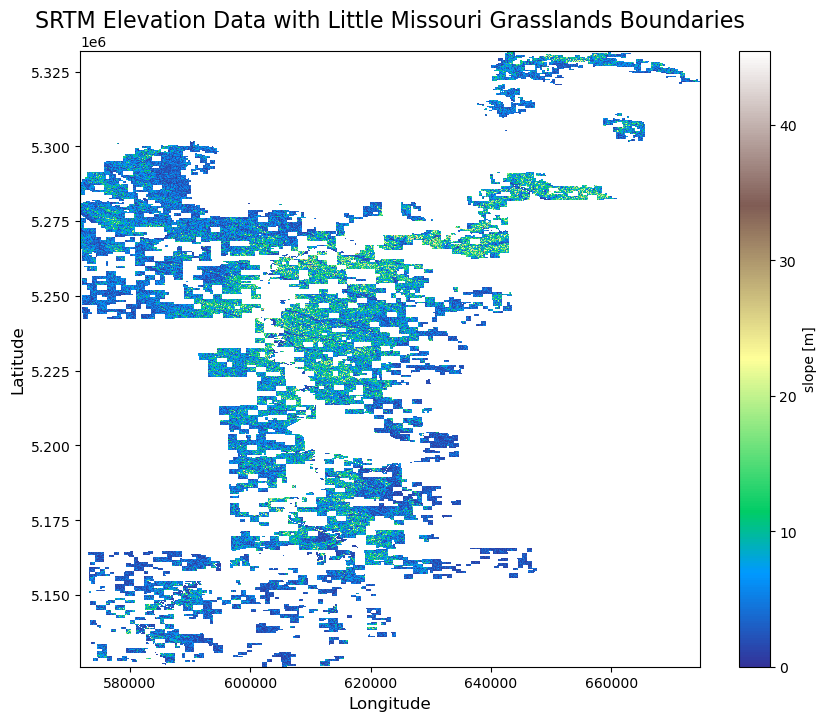

In [79]:
# Reproject and calculate slope
utm13_epsg = 32613
habitat2_srtm_project_da = habitat2_srtm_da.rio.reproject(32613)
habitat2_proj_gdf = habitat2_gdf.to_crs(utm13_epsg)

# Calculate slope
habitat2_slope_full_da = xrspatial.slope(habitat2_srtm_project_da)

# Clip the slope data by the habitat2 boundaries
habitat2_slope_da = habitat2_slope_full_da.rio.clip(habitat2_proj_gdf.geometry)

# Create a figure and axes to ensure consistent plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the slope data
habitat2_slope_da.plot(ax=ax, cmap='terrain')

# Add the Habitat 2 boundary on top in yellow (I took out the boundary because it was obscuring a lot of the raster data)
# habitat2_proj_gdf.boundary.plot(ax=ax, color='yellow')

# Add a title and labels after plotting
ax.set_title('SRTM Elevation Data with Little Missouri Grasslands Boundaries', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Show the plot
plt.show()


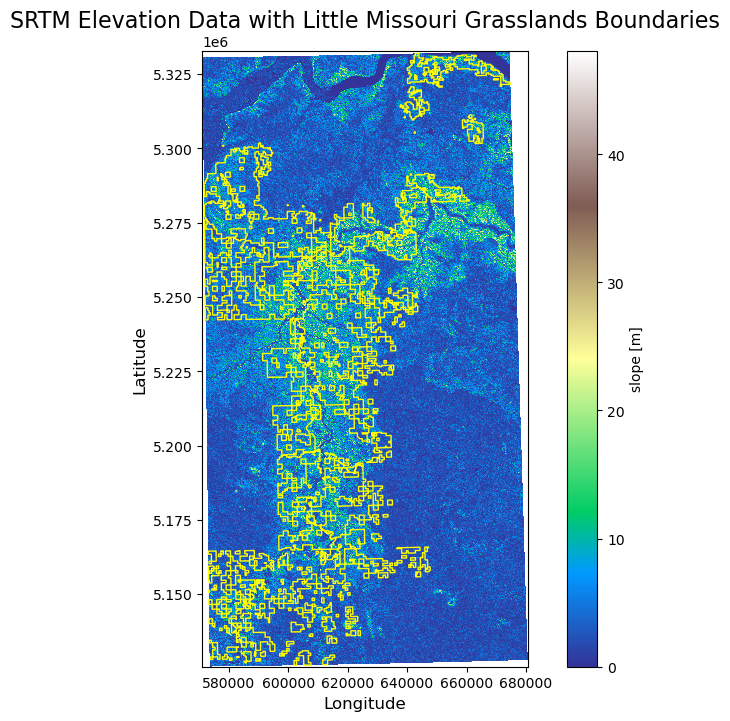

In [88]:
# Calculate the slope
habitat2_slope_da = xrspatial.slope(habitat2_srtm_project_da)

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the slope on the specified axis
habitat2_slope_da.plot(ax=ax, cmap='terrain')

# Add the Habitat 2 boundary
habitat2_gdf.to_crs(utm13_epsg).boundary.plot(ax=ax, color='yellow', linewidth=1)

# Add a title and labels after plotting
ax.set_title('SRTM Elevation Data with Little Missouri Grasslands Boundaries', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Display the plot
plt.show()


In [77]:
%store habitat1_gdf habitat2_gdf habitat1_srtm_da habitat2_srtm_da

Stored 'habitat1_gdf' (GeoDataFrame)
Stored 'habitat2_gdf' (GeoDataFrame)
Stored 'habitat1_srtm_da' (DataArray)


UsageError: Unknown variable 'habitat2_srtm_da'
